In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import single_meteor_score
from nltk.tokenize import word_tokenize
!pip install rouge
from rouge import Rouge
!pip install bert-score
import bert_score
import os
warnings.filterwarnings('ignore')


plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False


colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
model_colors = {
    'Model1': '#FF6B6B',
    'Model2': '#4ECDC4',
    'Model3': '#45B7D1'
}

In [ ]:
def read_result_csv(file_path):

    result_df = pd.read_csv(file_path)

    if result_df.columns[0] == 'Unnamed: 0':
        result_df.drop(result_df.columns[0], axis=1, inplace=True)
    return result_df

def clean_text(text):

    regex = r"[^a-zA-Z0-9.,!?;:'\"()\[\]{}\-\s]"
    cleaned_text = re.sub(regex, '', text)
    lines = re.split(r'(?<=[.!?]) +', cleaned_text)
    seen = set()
    unique_lines = []
    for line in lines:
        cleaned_line = re.sub(r'\s+', ' ', line).strip()
        if cleaned_line not in seen:
            seen.add(cleaned_line)
            unique_lines.append(cleaned_line)
    unique_lines = unique_lines[:1]
    result = ' '.join(unique_lines)
    return result

def cleanup_pred_captions(predicted_captions, model_name):

    predicted_captions = predicted_captions.fillna('')
    clean_captions = []

    for caption in predicted_captions:
        clean_caption = "No response."
        if caption.strip():

            if model_name in ['Deepseek', 'Advanced_DS']:

                system_match = re.search(r'<s>System:\s*(.*?)</s>', caption)
                if system_match:
                    clean_caption = system_match.group(1).strip()
                else:

                    lines = caption.split('\n')
                    first_line = lines[0].strip() if lines else caption

                    first_line = re.sub(r'<s>|</s>', '', first_line)
                    first_line = re.sub(r'System:\s*', '', first_line)
                    clean_caption = first_line.strip()
            else:

                clean_caption = clean_text(caption)

            if not clean_caption.strip():
                clean_caption = "No response."

        clean_captions.append(clean_caption)

    return clean_captions

In [ ]:
def compute_bleu(reference, candidate):

    reference = [[ref.split()] for ref in reference]
    candidate = [cand.split() for cand in candidate]
    smoothing_function = SmoothingFunction().method4
    bleu_scores = [corpus_bleu([ref], [cand], smoothing_function=smoothing_function)
                   for ref, cand in zip(reference, candidate)]
    mean_bleu_score = np.mean(bleu_scores)
    bleu_std_dev = np.std(bleu_scores)
    return round(mean_bleu_score, 3), round(bleu_std_dev, 3)

def compute_bleu_unigram(reference, candidate):

    reference = [[ref.split()] for ref in reference]
    candidate = [cand.split() for cand in candidate]
    smoothing_function = SmoothingFunction().method4
    weights = (1, 0, 0, 0)
    bleu_scores = [corpus_bleu([ref], [cand], smoothing_function=smoothing_function, weights=weights)
                   for ref, cand in zip(reference, candidate)]
    mean_bleu_score = round(np.mean(bleu_scores), 3)
    bleu_std_dev = round(np.std(bleu_scores), 3)
    return mean_bleu_score, bleu_std_dev

def compute_rouge(reference, candidate):

    rouge = Rouge()
    rouge_scores = [rouge.get_scores(cand, ref, avg=True)
                    for ref, cand in zip(reference, candidate)]

    rouge_1_f_scores = [score['rouge-1']['f'] for score in rouge_scores]
    rouge_2_f_scores = [score['rouge-2']['f'] for score in rouge_scores]
    rouge_l_f_scores = [score['rouge-l']['f'] for score in rouge_scores]

    mean_rouge_1_f_score = np.mean(rouge_1_f_scores)
    mean_rouge_2_f_score = np.mean(rouge_2_f_scores)
    mean_rouge_l_f_score = np.mean(rouge_l_f_scores)

    rouge_1_f_std_dev = np.std(rouge_1_f_scores)
    rouge_2_f_std_dev = np.std(rouge_2_f_scores)
    rouge_l_f_std_dev = np.std(rouge_l_f_scores)

    return (round(mean_rouge_1_f_score, 3), round(mean_rouge_2_f_score, 3),
            round(mean_rouge_l_f_score, 3), round(rouge_1_f_std_dev, 3),
            round(rouge_2_f_std_dev, 3), round(rouge_l_f_std_dev, 3))

def compute_bert_score(reference, candidate):

    bert_p_scores, bert_r_scores, bert_f1_scores = bert_score.score(
        candidate, reference, lang="en", verbose=False)
    return round(bert_f1_scores.mean().item(), 3), round(bert_f1_scores.std().item(), 3)

def compute_meteor_scores(reference, candidate):

    tokenized_candidates = [word_tokenize(candidate.replace("<s>", "").replace("</s>", "").strip())
                            for candidate in candidate]
    tokenized_references = [word_tokenize(sentence) for sentence in reference]
    meteor_scores = []
    for ref_sentence, candidate in zip(tokenized_references, tokenized_candidates):
        meteor_scores.append(single_meteor_score(ref_sentence, candidate))
    meteor_scores_mean = sum(meteor_scores) / len(meteor_scores)
    meteor_scores_std = np.std(meteor_scores)
    return round(meteor_scores_mean, 3), round(meteor_scores_std, 3)

In [ ]:
def analyze_csv_file(csv_path, model_name):

    print(f" {model_name}...")

    try:

        result_df = read_result_csv(csv_path)


        required_columns = ['Expected Caption', 'Generated Caption']
        for col in required_columns:
            if col not in result_df.columns:

                similar_cols = [c for c in result_df.columns if col.lower() in c.lower()]
                if similar_cols:
                    print(f"  警告: 未找到列 '{col}'，使用相似的列 '{similar_cols[0]}'")
                    result_df = result_df.rename(columns={similar_cols[0]: col})
                else:
                    raise ValueError(f"CSV文件中缺少必要的列: {col}")


        expected_captions = result_df['Expected Caption']
        predicted_captions = result_df['Generated Caption']


        predicted_captions_clean = cleanup_pred_captions(predicted_captions, model_name)

        references = expected_captions.tolist()
        candidates = predicted_captions_clean


        for i, cand in enumerate(candidates):
            if len(cand) <= 1:
                candidates[i] = "No response"


        results = {}

        # BLEU Score
        mean_bleu_score, bleu_std_dev = compute_bleu(references, candidates)
        results["Mean BLEU Score"] = mean_bleu_score
        results["SD BLEU Score"] = bleu_std_dev

        # BLEU Unigram Score
        mean_bleu_score_uni, bleu_std_dev_uni = compute_bleu_unigram(references, candidates)
        results["Mean BLEU Unigram Score"] = mean_bleu_score_uni
        results["SD BLEU Unigram Score"] = bleu_std_dev_uni

        # ROUGE Score
        (mean_rouge_1, mean_rouge_2, mean_rouge_l,
         rouge_1_std, rouge_2_std, rouge_l_std) = compute_rouge(references, candidates)
        results["Mean ROUGE-1"] = mean_rouge_1
        results["SD ROUGE-1"] = rouge_1_std
        results["Mean ROUGE-2"] = mean_rouge_2
        results["SD ROUGE-2"] = rouge_2_std
        results["Mean ROUGE-l"] = mean_rouge_l
        results["SD ROUGE-l"] = rouge_l_std

        # METEOR Score
        mean_meteor_score, meteor_std_dev = compute_meteor_scores(references, candidates)
        results["Mean Meteor Score"] = mean_meteor_score
        results["SD Meteor Score"] = meteor_std_dev

        # BERT Score
        bert_score_mean, bert_score_std = compute_bert_score(references, candidates)
        results["Mean BERTScore"] = bert_score_mean
        results["SD BERTScore"] = bert_score_std

        # number
        results["number"] = len(references)

        # model
        results["model"] = model_name

        print(f"  {model_name} 处理完成，共 {len(references)} 个样本")
        return results

    except Exception as e:
        print(f"  处理 {model_name} 时出错: {str(e)}")
        return None

In [ ]:

csv_paths = [
    "../content/mistral_results.csv",
    "../content/deepseek_eeg_model_7B_base_results.csv",
    "../content/advanced_deepseek.csv"
]

model_names = ["Mistral", "Deepseek", "Advanced_DS"]


In [ ]:

!pip install nltk
import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')
all_results = {}

for csv_path, model_name in zip(csv_paths, model_names):
    results = analyze_csv_file(csv_path, model_name)
    if results:
        all_results[model_name] = results

print(f"\n {len(all_results)} ")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


 Mistral...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Mistral 处理完成，共 1987 个样本
 Deepseek...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Deepseek 处理完成，共 1987 个样本
 Advanced_DS...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Advanced_DS 处理完成，共 1987 个样本

 3 


In [ ]:

results_df = pd.DataFrame(all_results).T
results_df

,Mean BLEU Score,SD BLEU Score,Mean BLEU Unigram Score,SD BLEU Unigram Score,Mean ROUGE-1,SD ROUGE-1,Mean ROUGE-2,SD ROUGE-2,Mean ROUGE-l,SD ROUGE-l,Mean Meteor Score,SD Meteor Score,Mean BERTScore,SD BERTScore,number,model
Mistral,0.065,0.091,0.27,0.148,0.32,0.153,0.094,0.13,0.289,0.144,0.271,0.171,0.895,0.027,1987,Mistral
Deepseek,0.033,0.049,0.168,0.126,0.262,0.135,0.047,0.087,0.244,0.124,0.182,0.108,0.888,0.022,1987,Deepseek
Advanced_DS,0.023,0.028,0.129,0.11,0.184,0.118,0.021,0.056,0.168,0.104,0.158,0.111,0.862,0.021,1987,Advanced_DS


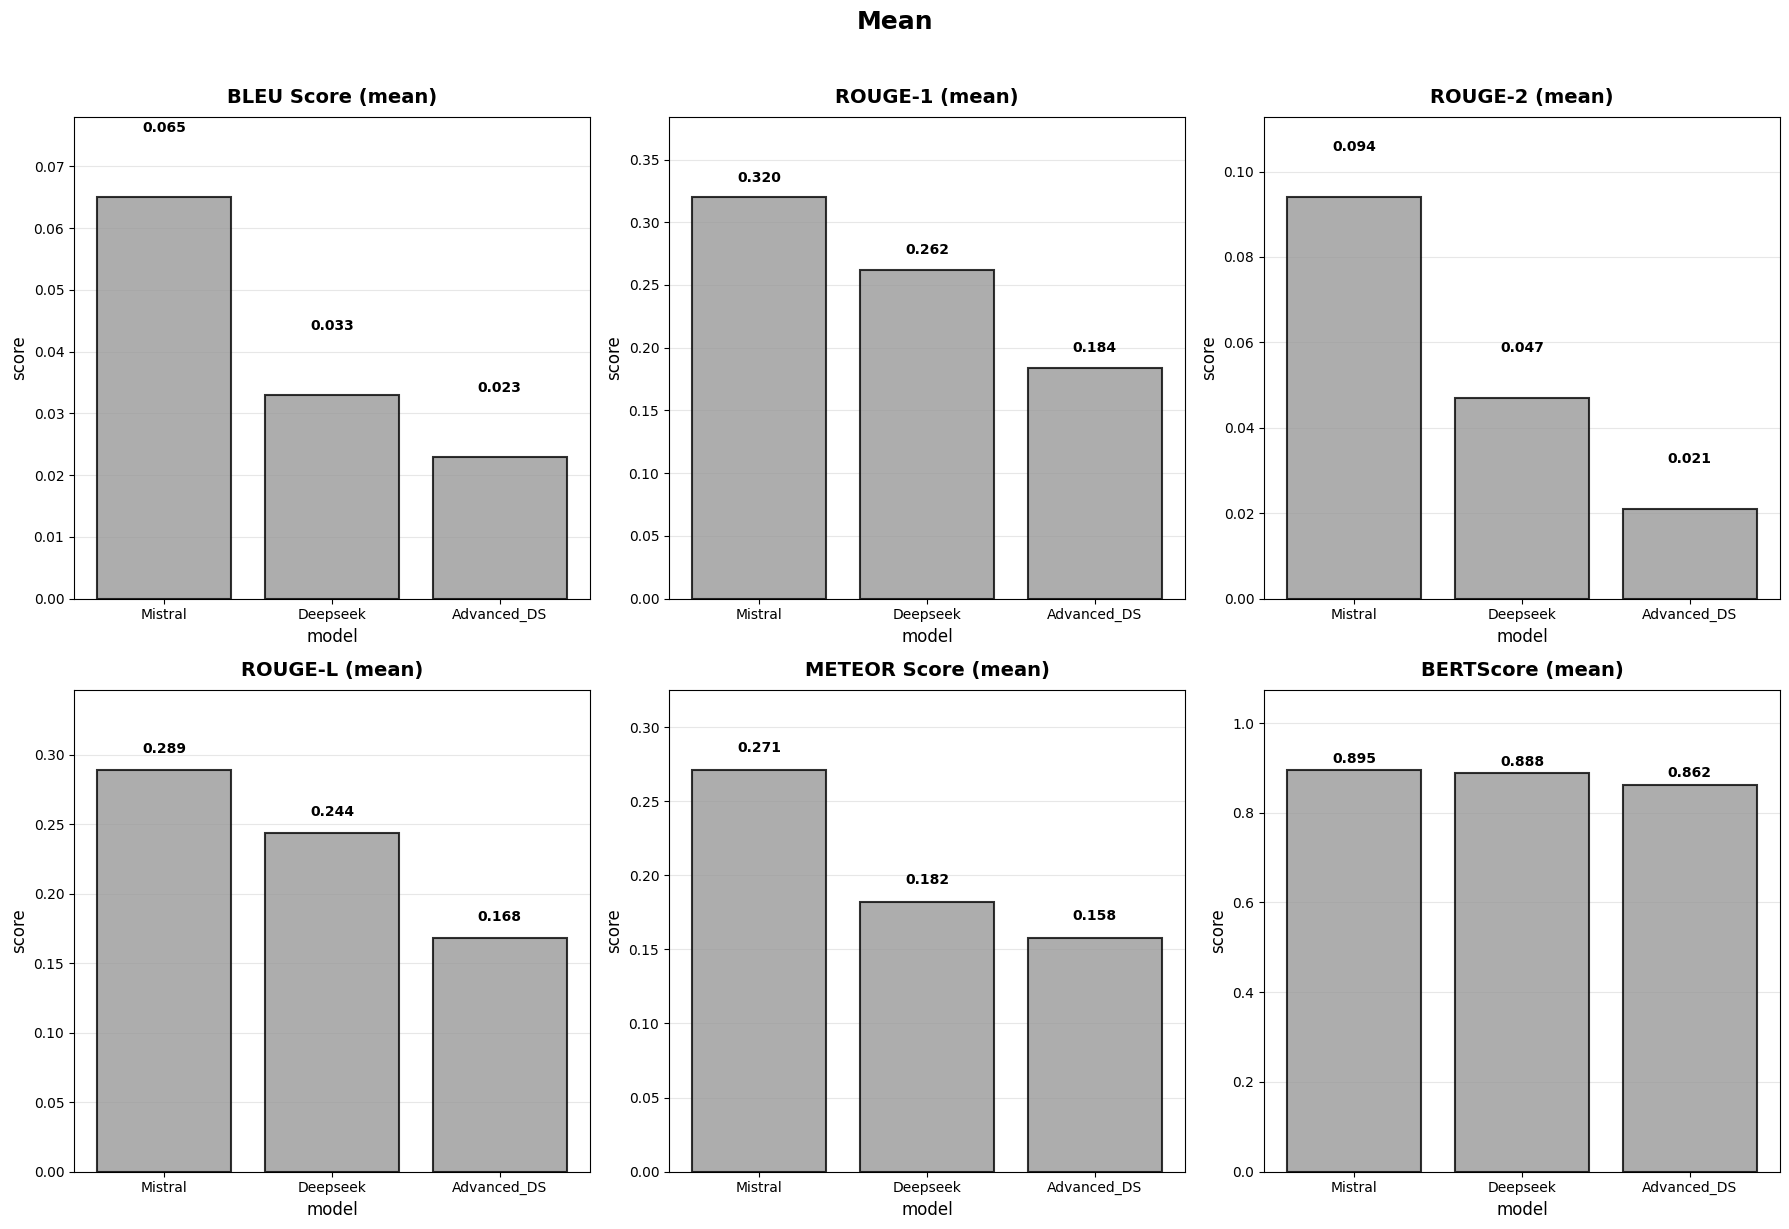

In [ ]:
def plot_main_metrics_comparison(results_df):

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Mean', fontsize=18, fontweight='bold', y=1.02)


    main_metrics = [
        ('Mean BLEU Score', 'BLEU Score', 'mean'),
        ('Mean ROUGE-1', 'ROUGE-1', 'mean'),
        ('Mean ROUGE-2', 'ROUGE-2', 'mean'),
        ('Mean ROUGE-l', 'ROUGE-L', 'mean'),
        ('Mean Meteor Score', 'METEOR Score', 'mean'),
        ('Mean BERTScore', 'BERTScore', 'mean')
    ]

    for idx, (metric, title, stat_type) in enumerate(main_metrics):
        ax = axes[idx // 3, idx % 3]


        models = list(results_df.index)
        values = [results_df.loc[model, metric] for model in models]


        bars = ax.bar(models, values, color=[model_colors.get(m, '#999999') for m in models],
                     alpha=0.8, edgecolor='black', linewidth=1.5)


        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

        ax.set_title(f'{title} ({stat_type})', fontsize=14, fontweight='bold', pad=10)
        ax.set_ylabel('score', fontsize=12)
        ax.set_xlabel('model', fontsize=12)
        ax.set_ylim(0, max(values) * 1.2 if max(values) > 0 else 1)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_axisbelow(True)

    plt.tight_layout()
    plt.savefig('三个模型主要指标对比.png', dpi=300, bbox_inches='tight')
    plt.show()


plot_main_metrics_comparison(results_df)

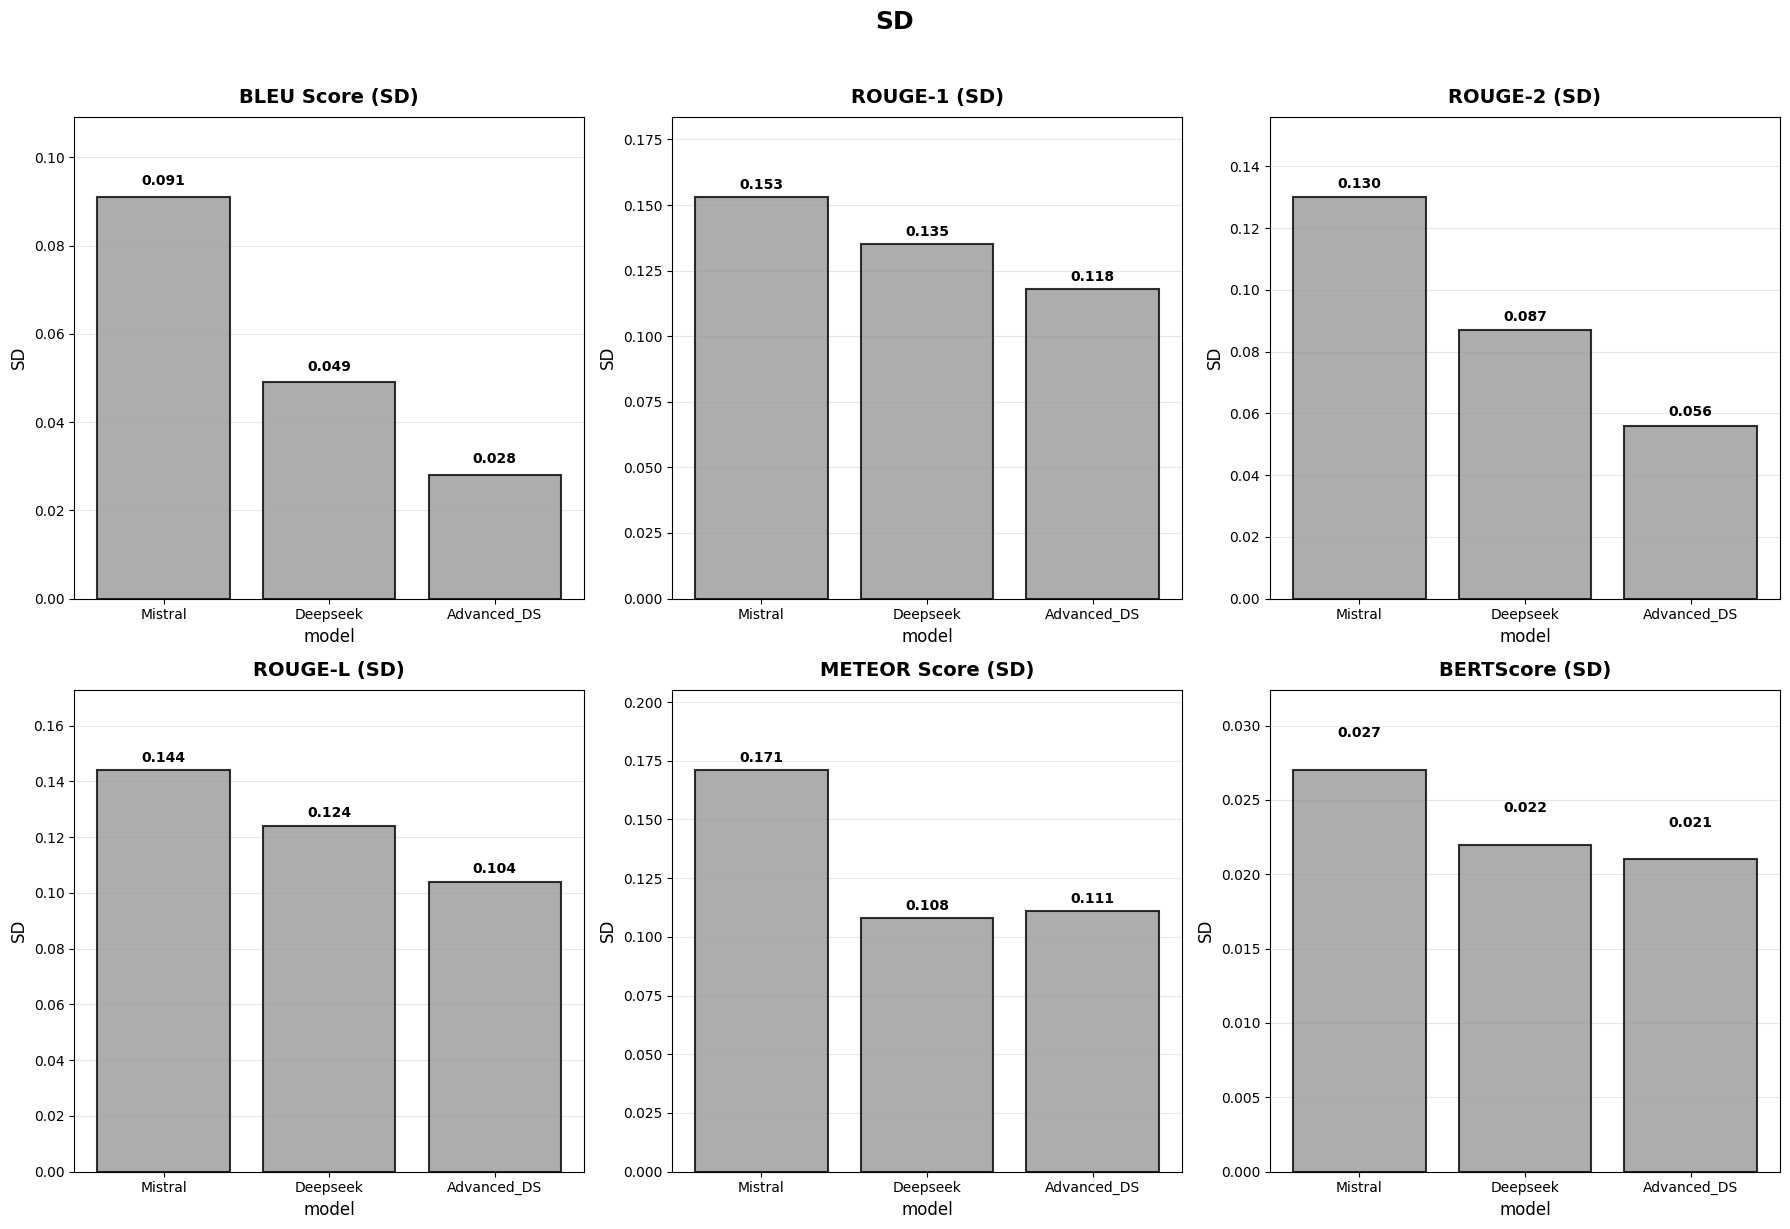

In [ ]:
def plot_std_metrics_comparison(results_df):

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('SD', fontsize=18, fontweight='bold', y=1.02)


    std_metrics = [
        ('SD BLEU Score', 'BLEU Score', 'SD'),
        ('SD ROUGE-1', 'ROUGE-1', 'SD'),
        ('SD ROUGE-2', 'ROUGE-2', 'SD'),
        ('SD ROUGE-l', 'ROUGE-L', 'SD'),
        ('SD Meteor Score', 'METEOR Score', 'SD'),
        ('SD BERTScore', 'BERTScore', 'SD')
    ]

    for idx, (metric, title, stat_type) in enumerate(std_metrics):
        ax = axes[idx // 3, idx % 3]


        models = list(results_df.index)
        values = [results_df.loc[model, metric] for model in models]


        bars = ax.bar(models, values, color=[model_colors.get(m, '#999999') for m in models],
                     alpha=0.8, edgecolor='black', linewidth=1.5)


        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.002,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

        ax.set_title(f'{title} ({stat_type})', fontsize=14, fontweight='bold', pad=10)
        ax.set_ylabel('SD', fontsize=12)
        ax.set_xlabel('model', fontsize=12)
        ax.set_ylim(0, max(values) * 1.2 if max(values) > 0 else 0.1)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_axisbelow(True)

    plt.tight_layout()
    plt.savefig('三个模型标准差对比.png', dpi=300, bbox_inches='tight')
    plt.show()


plot_std_metrics_comparison(results_df)

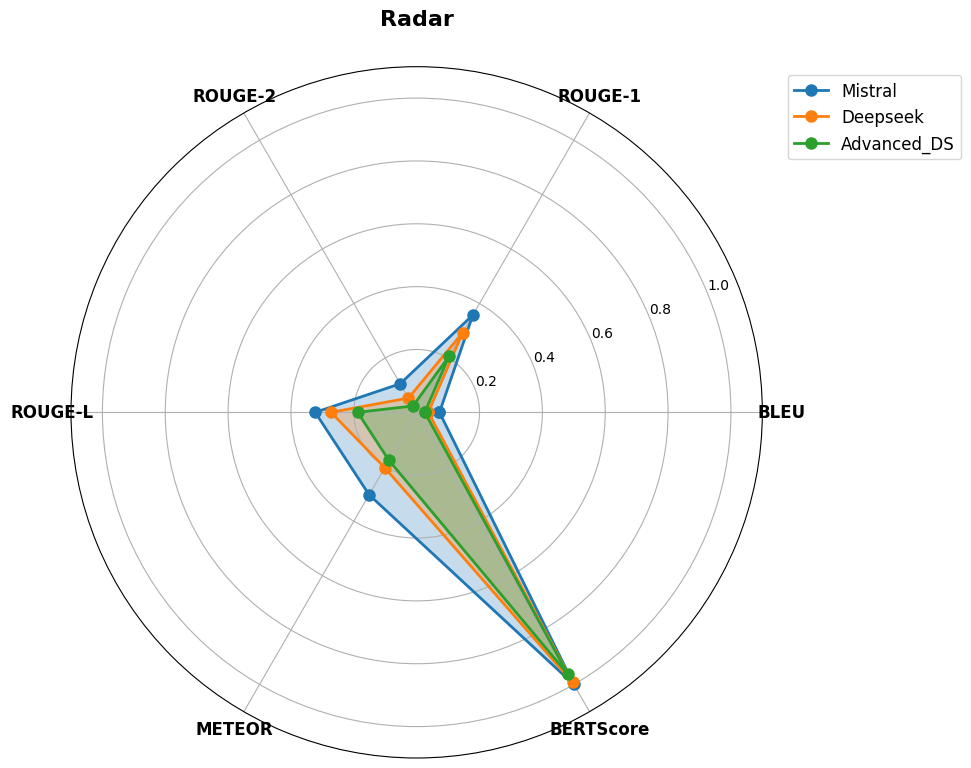

In [ ]:
def plot_radar_comparison(results_df):



    metrics = ['Mean BLEU Score', 'Mean ROUGE-1', 'Mean ROUGE-2',
               'Mean ROUGE-l', 'Mean Meteor Score', 'Mean BERTScore']

    labels = ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR', 'BERTScore']
    num_vars = len(labels)


    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))


    for model_idx, model in enumerate(results_df.index):

        values = []
        for metric in metrics:
            val = results_df.loc[model, metric]
            values.append(val)


        max_val = max([results_df.loc[m, metric] for m in results_df.index for metric in metrics])
        values_normalized = [v / max_val for v in values]
        values_normalized += values_normalized[:1]  # 闭合图形


        ax.plot(angles, values_normalized, 'o-', linewidth=2, label=model,
                color=model_colors.get(model, f'C{model_idx}'), markersize=8)
        ax.fill(angles, values_normalized, alpha=0.25, color=model_colors.get(model, f'C{model_idx}'))


    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=12, fontweight='bold')


    ax.set_ylim(0, 1.1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)

    ax.set_title('Radar', fontsize=16, fontweight='bold', pad=30)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=12)
    ax.grid(True)

    plt.tight_layout()
    plt.savefig('三个模型雷达图对比.png', dpi=300, bbox_inches='tight')
    plt.show()


plot_radar_comparison(results_df)

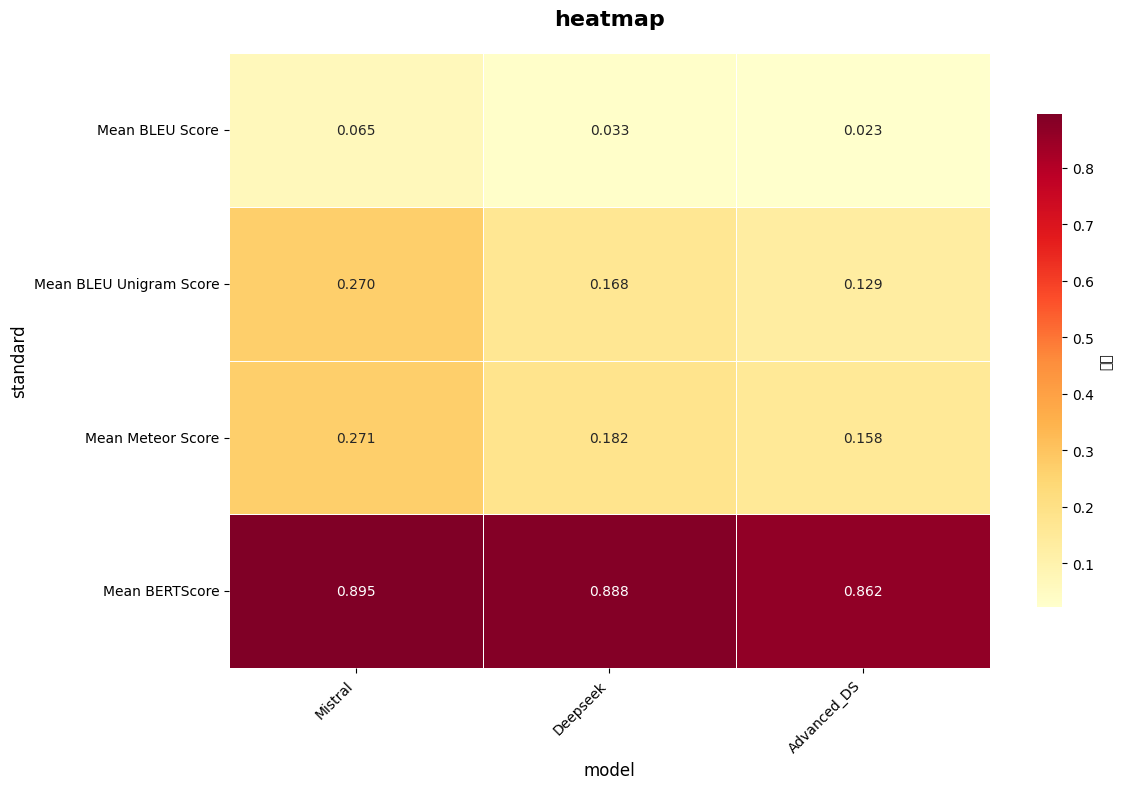

In [ ]:
def plot_heatmap_comparison(results_df):



    mean_metrics = [col for col in results_df.columns if 'Mean' in col and 'Score' in col]


    heatmap_data = results_df[mean_metrics].T

    for col in heatmap_data.columns:
        heatmap_data[col] = pd.to_numeric(heatmap_data[col], errors='coerce')


    plt.figure(figsize=(12, 8))


    sns.heatmap(heatmap_data,
                annot=True,
                fmt='.3f',
                cmap='YlOrRd',
                linewidths=0.5,
                linecolor='white',
                cbar_kws={'label': '得分', 'shrink': 0.8})

    plt.title('heatmap', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('model', fontsize=12)
    plt.ylabel('standard', fontsize=12)
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig('三个模型热力图对比.png', dpi=300, bbox_inches='tight')
    plt.show()

# 执行可视化
plot_heatmap_comparison(results_df)

In [ ]:
# 保存结果到CSV
results_df.to_csv("analysis.csv", encoding='utf-8-sig')
